In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import tensorflow as tf


In [13]:
class_names = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat',
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

# **training the cnn**

In [2]:
# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the dataset for a single channel
])

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=49, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=49, shuffle=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 116MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 6.77MB/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 54.2MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 16.6MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the CNN layers (Conv2D, MaxPool, Fully Connected)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 512)
        self.fc2 = nn.Linear(512, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + relu activation + pool
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + relu activation + pool
        x = x.view(-1, 64*7*7)  # Flatten the tensor
        x = torch.relu(self.fc1(x))  # Fully connected layer + relu activation
        x = self.fc2(x)  # Output layer
        return x

In [8]:
# Initialize the CNN model, loss function, and optimizer
model_cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

In [9]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [100/1225], Loss: 0.4277
Epoch [1/5], Step [200/1225], Loss: 0.2836
Epoch [1/5], Step [300/1225], Loss: 0.4725
Epoch [1/5], Step [400/1225], Loss: 0.3597
Epoch [1/5], Step [500/1225], Loss: 0.6038
Epoch [1/5], Step [600/1225], Loss: 0.3294
Epoch [1/5], Step [700/1225], Loss: 0.2004
Epoch [1/5], Step [800/1225], Loss: 0.3491
Epoch [1/5], Step [900/1225], Loss: 0.4297
Epoch [1/5], Step [1000/1225], Loss: 0.2175
Epoch [1/5], Step [1100/1225], Loss: 0.1419
Epoch [1/5], Step [1200/1225], Loss: 0.1868
Epoch [2/5], Step [100/1225], Loss: 0.3474
Epoch [2/5], Step [200/1225], Loss: 0.1863
Epoch [2/5], Step [300/1225], Loss: 0.3557
Epoch [2/5], Step [400/1225], Loss: 0.1773
Epoch [2/5], Step [500/1225], Loss: 0.2048
Epoch [2/5], Step [600/1225], Loss: 0.1644
Epoch [2/5], Step [700/1225], Loss: 0.3793
Epoch [2/5], Step [800/1225], Loss: 0.6231
Epoch [2/5], Step [900/1225], Loss: 0.2723
Epoch [2/5], Step [1000/1225], Loss: 0.2428
Epoch [2/5], Step [1100/1225], Loss: 0.2806
Epoch 

In [11]:
# Test the CNN model
model_cnn.eval()
all_preds_cnn = []
all_labels_cnn = []

with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_cnn(images)  # forward pass through the CNN
        _, predicted = torch.max(outputs.data, 1)
        all_preds_cnn.extend(predicted.cpu().numpy())
        all_labels_cnn.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, and F1-score for the CNN
accuracy_cnn = accuracy_score(all_labels_cnn, all_preds_cnn)  # with the correct calculation
precision_cnn = precision_score(all_labels_cnn, all_preds_cnn, average='weighted')
recall_cnn = recall_score(all_labels_cnn, all_preds_cnn, average='weighted')
f1_cnn = f1_score(all_labels_cnn, all_preds_cnn, average='weighted')

print(f"CNN Accuracy: {accuracy_cnn:.4f}")
print(f"CNN Precision: {precision_cnn:.4f}")
print(f"CNN Recall: {recall_cnn:.4f}")
print(f"CNN F1-Score: {f1_cnn:.4f}")

CNN Accuracy: 0.9112
CNN Precision: 0.9141
CNN Recall: 0.9112
CNN F1-Score: 0.9116


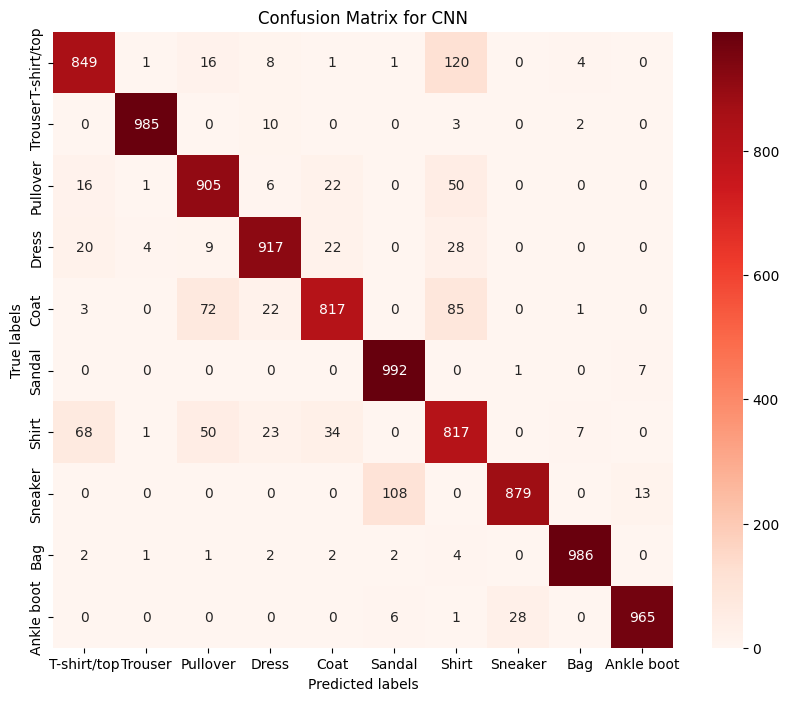

In [14]:
# Set the model to evaluation mode
model_cnn.eval()

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over the test data
with torch.no_grad():  # Disable gradient calculations during inference
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())  # Add true labels to the list
        y_pred.extend(predicted.cpu().numpy())  # Add predicted labels to the list

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for CNN')
plt.show()

# **comparison**

In [22]:
from keras import layers, models

In [24]:
def mlp1(input_shape):
  model = models.Sequential(name='MLP1')
  model.add(layers.Flatten(input_shape=input_shape))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(512, activation = 'relu', use_bias = True, kernel_initializer = 'he_uniform'))
  model.add(layers.Dropout(0.10))
  model.add(layers.Dense(10, activation = 'softmax', use_bias = True, kernel_initializer = 'he_uniform'))
  return model

def mlp2(input_shape):
  model = models.Sequential(name='MLP2')
  model.add(layers.Flatten(input_shape=input_shape))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(512, activation = 'relu', use_bias = True, kernel_initializer = 'he_uniform'))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(256, activation = 'relu', use_bias = True, kernel_initializer = 'he_uniform'))
  model.add(layers.Dropout(0.10))
  model.add(layers.Dense(10, activation = 'softmax', use_bias = True, kernel_initializer = 'he_uniform'))
  return model

def mlp3(input_shape):
  model = models.Sequential(name='MLP3')
  model.add(layers.Flatten(input_shape=input_shape))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(512, activation = 'relu', use_bias = True, kernel_initializer = 'he_uniform'))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(256, activation = 'relu', use_bias = True, kernel_initializer = 'he_uniform'))
  model.add(layers.Dropout(0.10))
  model.add(layers.Dense(128, activation = 'relu', use_bias = True, kernel_initializer = 'he_uniform'))
  model.add(layers.Dropout(0.10))
  model.add(layers.Dense(10, activation = 'softmax', use_bias = True, kernel_initializer = 'he_uniform'))
  return model

In [28]:
# Load the FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)

# Access the training and testing data
X_train = train_dataset.data.numpy()  # Convert to NumPy array
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()


# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [32]:
input_shape = (28, 28, 1)  # Input shape for FashionMNIST images
model_mlp1 = mlp1(input_shape)

model_mlp1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history1 = model_mlp1.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size = 512)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6518 - loss: 0.9899 - val_accuracy: 0.8293 - val_loss: 0.4913
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8213 - loss: 0.5083 - val_accuracy: 0.8532 - val_loss: 0.4234
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8406 - loss: 0.4540 - val_accuracy: 0.8622 - val_loss: 0.3924
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8527 - loss: 0.4165 - val_accuracy: 0.8615 - val_loss: 0.3914
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8580 - loss: 0.3942 - val_accuracy: 0.8696 - val_loss: 0.3738
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8649 - loss: 0.3764 - val_accuracy: 0.8715 - val_loss: 0.3609
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8663 - loss: 0.3686 - val_accuracy: 0.8783 - val_loss: 0.3435
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8713 - loss: 0.3521 - val_accuracy: 0.8796 - v

In [33]:
input_shape = (28, 28, 1)  # Input shape for FashionMNIST images
model_mlp2 = mlp2(input_shape)

model_mlp2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history1 = model_mlp2.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size = 512)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6508 - loss: 0.9873 - val_accuracy: 0.8348 - val_loss: 0.4672
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8262 - loss: 0.4859 - val_accuracy: 0.8491 - val_loss: 0.4170
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8408 - loss: 0.4348 - val_accuracy: 0.8622 - val_loss: 0.3809
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8520 - loss: 0.4068 - val_accuracy: 0.8673 - val_loss: 0.3626
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.8574 - loss: 0.3813 - val_accuracy: 0.8722 - val_loss: 0.3512
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8608 - loss: 0.3767 - val_accuracy: 0.8748 - val_loss: 0.3453
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8720 - loss: 0.3467 - val_accuracy: 0.8758 - val_loss: 0.3367
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8729 - loss: 0.3410 - val_accuracy: 0.8791 - v

In [34]:
input_shape = (28, 28, 1)  # Input shape for FashionMNIST images
model_mlp3 = mlp1(input_shape)

model_mlp3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history1 = model_mlp3.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size = 512)



Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6512 - loss: 1.0041 - val_accuracy: 0.8273 - val_loss: 0.5040
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.8203 - loss: 0.5077 - val_accuracy: 0.8483 - val_loss: 0.4264
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8457 - loss: 0.4428 - val_accuracy: 0.8650 - val_loss: 0.3931
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8527 - loss: 0.4143 - val_accuracy: 0.8648 - val_loss: 0.3822
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8588 - loss: 0.3914 - val_accuracy: 0.8734 - val_loss: 0.3647
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8656 - loss: 0.3735 - val_accuracy: 0.8765 - val_loss: 0.3536
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8694 - loss: 0.3632 - val_accuracy: 0.8786 - val_loss: 0.3437
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8718 - loss: 0.3497 - val_accuracy: 0.8794 - v

In [36]:
res = []
res.append(model_mlp1.evaluate(X_test,y_test))
res.append(model_mlp2.evaluate(X_test,y_test))
res.append(model_mlp3.evaluate(X_test,y_test))

for i, result in enumerate(res, start=1):
    print(f"Evaluation results for mlp{i}:")
    print("Loss:", result[0])
    print("Accuracy:", result[1], "\n")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8846 - loss: 0.3219
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8849 - loss: 0.3156
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8807 - loss: 0.3247
Evaluation results for mlp1:
Loss: 0.32376015186309814
Accuracy: 0.8848000168800354 

Evaluation results for mlp2:
Loss: 0.3169262409210205
Accuracy: 0.8830000162124634 

Evaluation results for mlp3:
Loss: 0.3287707567214966
Accuracy: 0.8809000253677368 



In [40]:
res[0][0]

0.32376015186309814

In [41]:
import pandas as pd

data = {
    'Model': ['CNN', 'mlp1', 'mlp2', 'mlp3'],
    'Accuracy': [accuracy_cnn, res[0][0], res[1][0], res[2][0]],
}

df_comparison = pd.DataFrame(data)
print(df_comparison)

  Model  Accuracy
0   CNN  0.911200
1  mlp1  0.323760
2  mlp2  0.316926
3  mlp3  0.328771
